In [254]:
import pandas as pd
import numpy as np
import torch
import tqdm
import os
import glob
import cv2
import skimage.metrics as metrics
import matplotlib.pyplot as plt
import re
import model as autoencoder
from torchvision import transforms
import matplotlib.lines as mlines

In [75]:
test_images_path = '/home/maciejka/Desktop/school/S8/labwork-project/db/dataset_preprocessed/test'
path_to_models = '/home/maciejka/Desktop/school/S8/labwork-project/models'
path_to_history = '/home/maciejka/Desktop/school/S8/labwork-project/history'

models = sorted(glob.glob(os.path.join(path_to_models,'*.pth')))
histories = sorted(glob.glob(os.path.join(path_to_history,'*.csv')))

test_gt = sorted(glob.glob(os.path.join(test_images_path,'input', '*.bmp')))
test_input = sorted(glob.glob(os.path.join(test_images_path,'output', '*.bmp')))



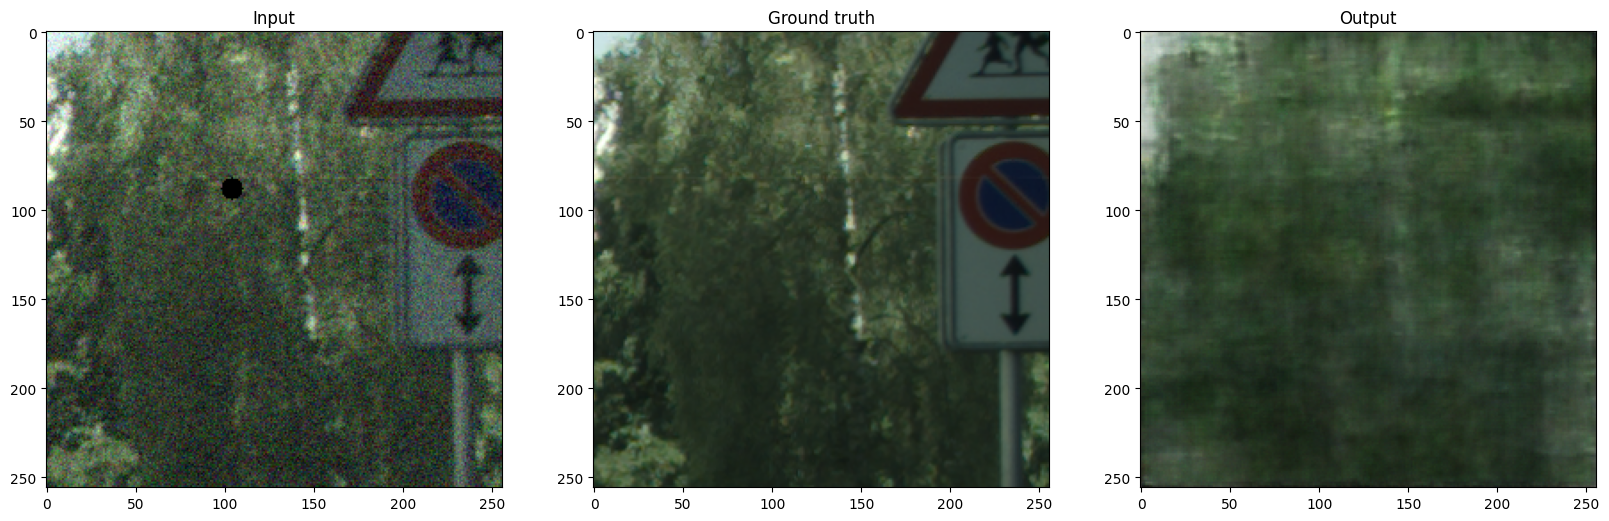

In [111]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
def get_model_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)Csize'
    zsize_pattern = r'_(\d+)Zsise'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def get_test_data_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)csize'
    zsize_pattern = r'_(\d+)zsize'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def load_model_and_history(loss, stacks, csize, zsize, only_history=False):
    model_regex = (os.path.join(path_to_models, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.pth'))
    history_regex = (os.path.join(path_to_history, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.csv'))

    model_path = glob.glob(model_regex)
    history_path = glob.glob(history_regex)
    history = pd.read_csv(*history_path)

    if not only_history:
        model = autoencoder.ChainedAutoencoder(int(stacks), 3 , int(csize), int(zsize))
        model.load_state_dict(torch.load(*model_path, map_location=torch.device('cpu')))
        return model, history
    else:
        return history


def load_test_data(loss, stacks, csize, zsize):
    test_data_regex = (os.path.join('test_data', f'test_data_{loss}_loss_{stacks}stacks_{csize}csize_{zsize}zsize.csv'))
    test_data_path = glob.glob(test_data_regex)
    return pd.read_csv(*test_data_path)



def classify_image(model, image, gt_path, output='metrics'):
    image_numpy = cv2.imread(image, cv2.IMREAD_COLOR)
    image_numpy = cv2.cvtColor(image_numpy, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    input_tensor = transform(image_numpy).unsqueeze(0)
    image_output = model(input_tensor)
    pred = image_output.detach().numpy()[0].transpose(1, 2, 0)

    mse = metrics.mean_squared_error(gt, pred)
    psnr = metrics.peak_signal_noise_ratio(gt, pred)

    ssim = metrics.structural_similarity(gt, pred, channel_axis=2, data_range=1)

    if output == 'metrics':
        return mse, psnr, ssim
    elif output == 'image':
        return pred
    else:
        raise ValueError("Invalid output type. Choose 'metrics' or 'image'.")


def test_image_context(model, im, gt):

    output = classify_image(model, im, gt, output='image')

    im_in = cv2.imread(im, cv2.IMREAD_COLOR)
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(im_in)
    ax[0].set_title('Input')
    ax[1].imshow(gt)
    ax[1].set_title('Ground truth')
    ax[2].imshow(output)
    ax[2].set_title('Output')

def calculate_metrics(model, test_input, test_gt):
    output_dict = {
        'img': [],
        'mse': [],
        'psnr': [],
        'ssim': [],
    }

    for in_path, gt_path in tqdm.tqdm(zip(test_input, test_gt), total=len(test_input), desc='Calculating metrics...', leave=False):
        mse, psnr, ssim = classify_image(model, in_path, gt_path, output='metrics')
        output_dict['img'].append(in_path)
        output_dict['mse'].append(mse)
        output_dict['psnr'].append(psnr)
        output_dict['ssim'].append(ssim)


    df = pd.DataFrame(output_dict)
    return df




infos = get_model_infos(models[20])
model, history = load_model_and_history('frequency', 1, 32, 512)
test_image_context(model, test_input[581], test_gt[581])


In [78]:
i = 1
for model_path in models:
    print('model {} / {}'.format(i, len(models)))
    loss, stacks, csize, zsize = get_model_infos(model_path)
    path = '/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_{}_loss_{}stacks_{}csize_{}zsize.csv'.format(loss, stacks, csize, zsize)
    print(path)
    model, history = load_model_and_history(loss, stacks, csize, zsize)
    met = calculate_metrics(model, test_input, test_gt)
    met.to_csv(path, index=False)
    i += 1

model 1 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_3stacks_64csize_256zsize.csv


model 2 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_3stacks_64csize_256zsize.csv


model 3 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_3stacks_128csize_128zsize.csv


model 4 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_3stacks_128csize_128zsize.csv


model 5 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_4stacks_32csize_512zsize.csv


model 6 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_4stacks_32csize_512zsize.csv


model 7 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_4stacks_64csize_256zsize.csv


model 8 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_4stacks_64csize_256zsize.csv


model 9 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_4stacks_128csize_128zsize.csv


model 10 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_4stacks_128csize_128zsize.csv


model 11 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_5stacks_32csize_512zsize.csv


model 12 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_5stacks_32csize_512zsize.csv


model 13 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_5stacks_64csize_256zsize.csv


model 14 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_5stacks_64csize_256zsize.csv


model 15 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_5stacks_128csize_128zsize.csv


model 16 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_5stacks_128csize_128zsize.csv


model 17 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_6stacks_32csize_512zsize.csv


model 18 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_6stacks_32csize_512zsize.csv


model 19 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_6stacks_64csize_256zsize.csv


model 20 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_6stacks_64csize_256zsize.csv


model 21 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_1stacks_32csize_512zsize.csv


model 22 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_1stacks_32csize_512zsize.csv


model 23 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_6stacks_128csize_128zsize.csv


model 24 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_6stacks_128csize_128zsize.csv


model 25 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_7stacks_32csize_512zsize.csv


model 26 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_7stacks_32csize_512zsize.csv


model 27 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_7stacks_64csize_256zsize.csv


model 28 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_7stacks_64csize_256zsize.csv


model 29 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_7stacks_128csize_128zsize.csv


model 30 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_7stacks_128csize_128zsize.csv


model 31 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_8stacks_32csize_512zsize.csv


model 32 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_8stacks_32csize_512zsize.csv


model 33 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_8stacks_64csize_256zsize.csv


model 34 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_8stacks_64csize_256zsize.csv


model 35 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_8stacks_128csize_128zsize.csv


model 36 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_8stacks_128csize_128zsize.csv


model 37 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_9stacks_32csize_512zsize.csv


model 38 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_9stacks_32csize_512zsize.csv


model 39 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_9stacks_64csize_256zsize.csv


model 40 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_9stacks_64csize_256zsize.csv


model 41 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_9stacks_128csize_128zsize.csv


model 42 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_9stacks_128csize_128zsize.csv


model 43 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_1stacks_64csize_256zsize.csv


model 44 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_1stacks_64csize_256zsize.csv


model 45 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_10stacks_32csize_512zsize.csv


model 46 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_10stacks_32csize_512zsize.csv


model 47 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_10stacks_64csize_256zsize.csv


model 48 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_10stacks_64csize_256zsize.csv


model 49 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_1stacks_128csize_128zsize.csv


model 50 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_1stacks_128csize_128zsize.csv


model 51 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_1stacks_256csize_64zsize.csv


model 52 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_1stacks_256csize_64zsize.csv


model 53 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_2stacks_32csize_512zsize.csv


model 54 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_2stacks_32csize_512zsize.csv


model 55 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_2stacks_64csize_256zsize.csv


model 56 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_2stacks_64csize_256zsize.csv


model 57 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_2stacks_128csize_128zsize.csv


model 58 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_2stacks_128csize_128zsize.csv


model 59 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_2stacks_256csize_64zsize.csv


model 60 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_2stacks_256csize_64zsize.csv


model 61 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_frequency_loss_3stacks_32csize_512zsize.csv


model 62 / 62
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_3stacks_32csize_512zsize.csv


In [99]:
test_datas = glob.glob(os.path.join('test_data', 'test_data_*.csv'))
output_dict = {
    'loss': [],
    'stacks': [],
    'csize': [],
    'zsize': [],

    'training_time': [],
    'loss_training': [],
    'mse': [],
    'psnr': [],
    'ssim': [],

}
for test_data in test_datas:
    loss, stacks, csize, zsize = get_test_data_infos(test_data)
    df_history = load_model_and_history(loss, stacks, csize, zsize, only_history=True)

    df_test = pd.read_csv(test_data)
    print(df_history)

    output_dict['loss'].append(loss)
    output_dict['stacks'].append(stacks)
    output_dict['csize'].append(csize)
    output_dict['zsize'].append(zsize)
    output_dict['training_time'].append(df_history['time'].iloc[-1])
    output_dict['loss_training'].append(df_history['val_loss'].iloc[-1])

    #
    mse = df_test['mse'].mean()
    psnr = df_test['psnr'].mean()
    ssim = df_test['ssim'].mean()

    output_dict['mse'].append(mse)
    output_dict['psnr'].append(psnr)
    output_dict['ssim'].append(ssim)

output_df = pd.DataFrame(output_dict)

output_df


    epoch      loss  val_loss        time
0       1  0.111107  0.099146   15.480562
1       2  0.105223  0.102040   30.806341
2       3  0.106383  0.100548   46.111287
3       4  0.105415  0.100231   61.431970
4       5  0.106343  0.101481   76.877897
5       6  0.105717  0.103779   92.080759
6       7  0.106001  0.099932  107.596086
7       8  0.107006  0.098886  122.775889
8       9  0.105576  0.101579  138.239684
9      10  0.104324  0.099723  153.676256
10     11  0.105878  0.103727  168.376440
11     12  0.104724  0.099353  183.491368
12     13  0.105033  0.101622  198.925098
13     14  0.106520  0.101375  214.315623
14     15  0.104757  0.100401  229.283859
15     16  0.105157  0.098781  244.634795
16     17  0.106361  0.102819  259.643926
17     18  0.105092  0.100466  275.121583
18     19  0.104838  0.103463  290.346106
19     20  0.104192  0.100054  305.581291
20     21  0.105594  0.099970  320.995282
21     22  0.105796  0.100654  336.383702
22     23  0.105198  0.102753  351

,loss,stacks,csize,zsize,training_time,loss_training,mse,psnr,ssim
0,frequency,4,32,512,688.750993,0.100633,0.068466,12.108572,0.196146
1,frequency,4,64,256,895.775961,0.100371,0.069483,12.073481,0.212533
2,frequency,3,64,256,927.531813,0.101083,0.069627,12.111539,0.197085
3,mse,10,64,256,1332.093791,0.060833,0.064681,12.480133,0.285828
4,frequency,3,128,128,1626.315865,0.101520,0.068411,12.141098,0.209564
...,...,...,...,...,...,...,...,...,...
57,frequency,1,256,64,2398.368839,0.411237,0.260449,5.967447,0.004872
58,mse,9,128,128,2206.841490,0.062166,0.064581,12.463658,0.286084
59,mse,8,64,256,1180.576624,0.062884,0.064551,12.453287,0.285747
60,mse,1,64,256,617.476211,0.029111,0.027180,16.356851,0.288834


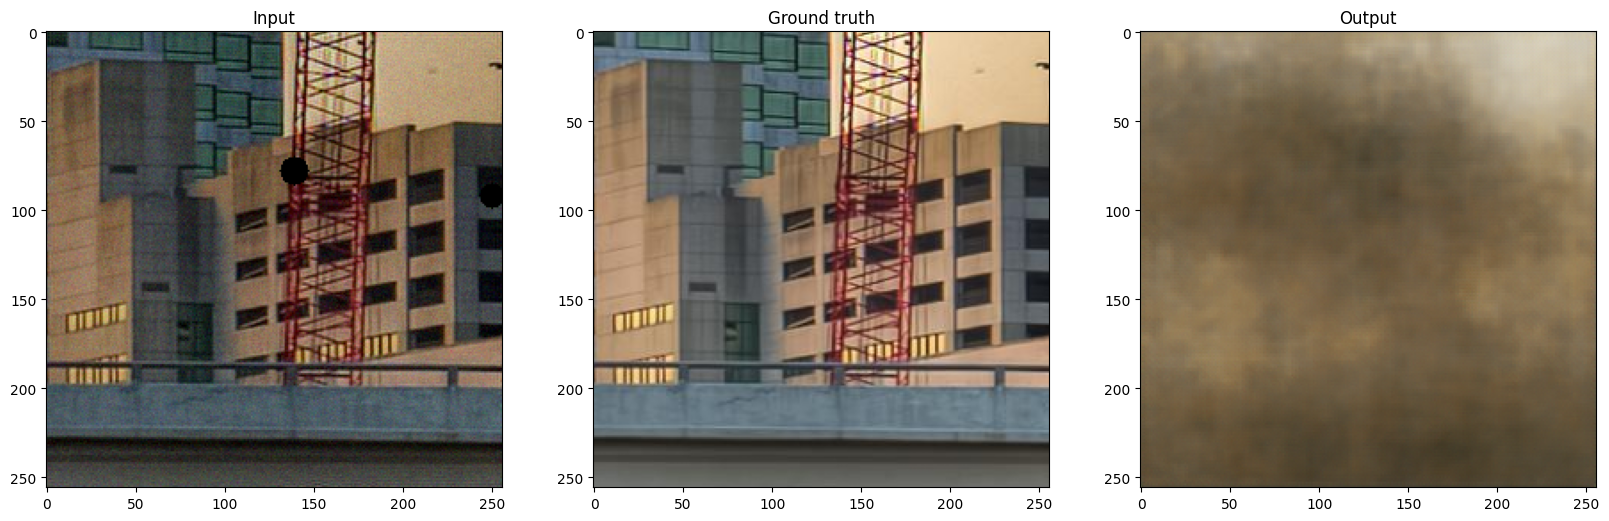

In [110]:
model, history = load_model_and_history('mse', 2, 64, 256)
test_image_context(model, test_input[123], test_gt[123])

t-statistic: 18.59119046534965, p-value: 3.297325973582056e-64


,img,mse,psnr,ssim,Loss type
0,/home/maciejka/Desktop/school/S8/labwork-proje...,0.008988,20.463462,0.458040,MSE loss
1,/home/maciejka/Desktop/school/S8/labwork-proje...,0.012434,19.053787,0.362547,MSE loss
2,/home/maciejka/Desktop/school/S8/labwork-proje...,0.055811,12.532809,0.278866,MSE loss
3,/home/maciejka/Desktop/school/S8/labwork-proje...,0.014441,18.404001,0.234726,MSE loss
4,/home/maciejka/Desktop/school/S8/labwork-proje...,0.008162,20.881962,0.377801,MSE loss
...,...,...,...,...,...
1567,/home/maciejka/Desktop/school/S8/labwork-proje...,0.020261,16.933304,0.260366,Frequency loss
1568,/home/maciejka/Desktop/school/S8/labwork-proje...,0.024006,16.196860,0.351145,Frequency loss
1569,/home/maciejka/Desktop/school/S8/labwork-proje...,0.038106,14.190095,0.299870,Frequency loss
1570,/home/maciejka/Desktop/school/S8/labwork-proje...,0.031382,15.033143,0.299291,Frequency loss


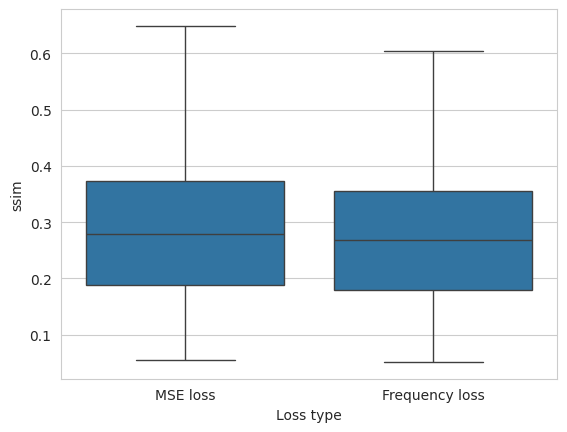

In [172]:
import seaborn as sns
from scipy import stats
# comparision - frequency vs mse
test_val = 'ssim'
data1 = ['mse', 1, 64, 256]
data2 = ['frequency', 1, 64, 256]

test_data_1 = load_test_data(*data1)
test_data_2 = load_test_data(*data2)

test_data_1['Loss type'] = 'MSE loss'
test_data_2['Loss type'] = 'Frequency loss'

df = pd.concat([test_data_1, test_data_2], ignore_index=True)

sns.boxplot(x='Loss type', y=test_val, data=df)#, split=True, inner='quartile')

t_stat, p_value = stats.ttest_rel(test_data_1[test_val], test_data_2[test_val], equal_var=False, alternative='two-sided')
print(f"t-statistic: {t_stat}, p-value: {p_value}")

df


t-statistic: 18.59119046534965, p-value: 3.297325973582056e-64


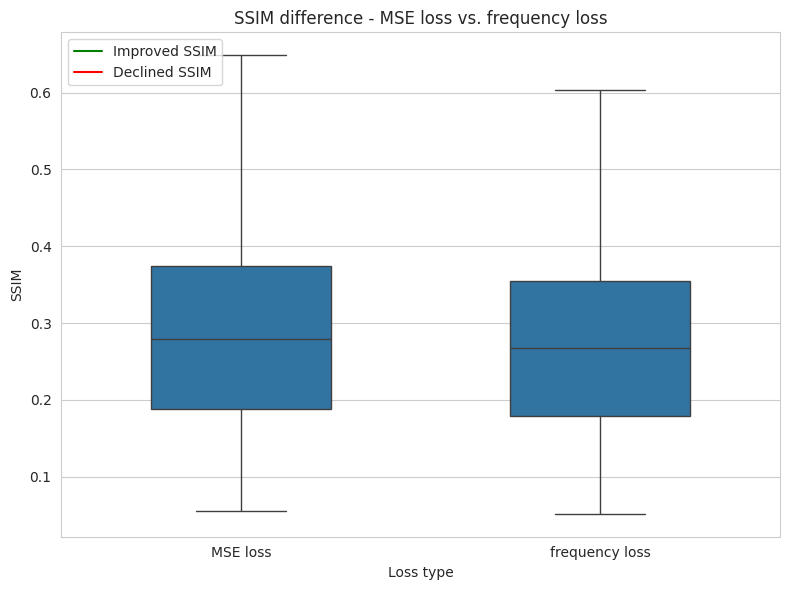

In [368]:


test_val = 'ssim'

data_1_diff = 'MSE loss'
data_2_diff = 'frequency loss'
data1 = ['mse', 1, 64, 256]
data2 = ['frequency', 1, 64, 256]

df1 = load_test_data(*data1)
df2 = load_test_data(*data2)
suffix1 = '{} - {}'.format(test_val, data_1_diff)
suffix2 = '{} - {}'.format(test_val, data_2_diff)

df = df1.merge(df2,
               on="img",
               suffixes=(" - {}".format(data_1_diff)," - {}".format(data_2_diff)))

a = df['{} - {}'.format(test_val, data_1_diff)]
b = df['{} - {}'.format(test_val, data_2_diff)]

t_stat, p_t = stats.ttest_rel(a, b, alternative='two-sided')

print(f"t-statistic: {t_stat}, p-value: {p_t}")


df_long = pd.melt(df, id_vars=['img'], value_vars=[suffix1, suffix2], var_name='Loss type', value_name=test_val)
df_long['Loss type'] = df_long['Loss type'].replace({suffix1: data_1_diff, suffix2: data_2_diff})


#plt.hist(df1[test_val] - df2[test_val], bins=42, label=data_1_diff)

plt.figure(figsize=(8,6))
sns.boxplot(x='Loss type', y=test_val, data=df_long, width=0.5, fliersize=3)

# overlay paired lines
x_coords = {'MSE loss':0, 'Frequency loss':1}
for _, row in df.iterrows():
    delta = row[suffix1] - row[suffix2]
    color = 'red' if delta > 0 else 'green'
    #plt.plot([x_coords['MSE loss'], x_coords['Frequency loss']], [row[suffix1], row[suffix2]], color=color, alpha=0.1, linewidth=0.4)


green_line = mlines.Line2D([], [], color='green', label='Improved SSIM')
red_line = mlines.Line2D([], [], color='red', label='Declined SSIM')

plt.legend(handles=[green_line, red_line], loc='upper left')

plt.title('SSIM difference - {} vs. {}'.format(data_1_diff, data_2_diff))
plt.xlabel('Loss type')
plt.ylabel('SSIM')



plt.tight_layout()
plt.show()


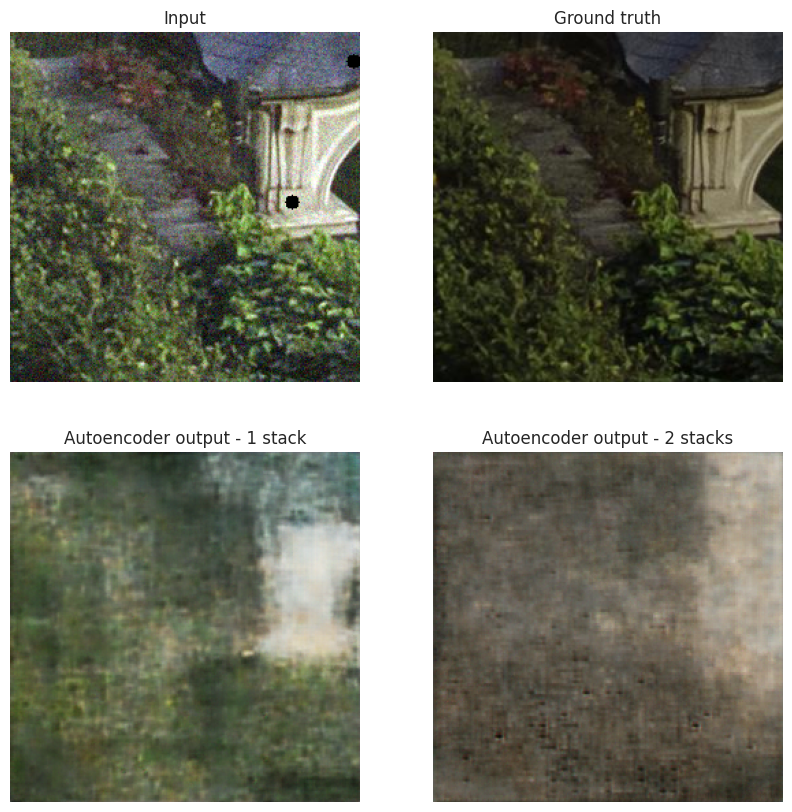

In [333]:
model1, _ = load_model_and_history(*data1)
model2, _ = load_model_and_history(*data2)
inx = 31


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
classify_image(model1, test_input[inx], test_gt[inx], output='image')

inp = cv2.imread(test_input[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)

gt = cv2.imread(test_gt[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

m1_output = classify_image(model1, test_input[inx], test_gt[inx], output='image')
m2_output = classify_image(model2, test_input[inx], test_gt[inx], output='image')

def show_image(ax, img, title):
    ax.imshow(img)
    ax.set_title(title)
    ax.grid(False)
    ax.axis('off')

show_image(ax[0, 0], inp, 'Input')
show_image(ax[0, 1], gt, 'Ground truth')
show_image(ax[1, 0], m1_output, 'Autoencoder output - 1 stack')
show_image(ax[1, 1], m2_output, 'Autoencoder output - 2 stacks')

